# Export Data ke Training Pipelines

In [9]:
print(tf.__version__)

2.19.0


## Import libraries

In [1]:
import pandas as pd
import numpy as np
    
import tensorflow as tf
    
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

2025-04-05 01:50:06.538261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743792606.639418   28169 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743792606.669036   28169 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743792606.886768   28169 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743792606.886803   28169 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743792606.886806   28169 computation_placer.cc:177] computation placer alr

## Load data

In [2]:
url= 'https://raw.githubusercontent.com/natashayulian/diamond_dataset/master/diamonds.csv'
df = pd.read_csv(url)

## Split data

In [3]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

34521 train examples
8631 validation examples
10788 test examples


In [4]:
#Membuat kolom target
# 0 = low; 1 = high
df['target'] = np.where(df['price'] <= 1000, 0, 1)
# Drop un-used columns.
df = df.drop(columns=['price'])

## Bungkus df

Kemudian bungkus dataframe dengan tf.data agar memungkinkan untuk menggunakan feature column sebagai jembatan dari dataframe menjadi fitur yang digunakan untuk train model. Jika file CSV nya sangat besar, kita harus menggunakan tf.data untuk membaca file tersebut dari harddisk.



In [6]:
# Cara untuk membuat dataset tf.data dari pandas dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = df.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds
batch_size = 10 #bath ukuran kecil untuk demonstrasi
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

2025-04-05 01:53:20.495639: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Ada beberapa jenis dari feature column yang dapat menjadi masukan TensorFlow:

- Numeric column: Numeric column merupakan jenis feature column yang paling sederhana dan digunakan untuk merepresentasikan sebuah fitur dengan value yang apa adanya. Masukkan ke TensorFlow harus berupa angka dan numeric column sudah merupakan angka sehingga tidak perlu diubah lagi.

In [7]:
example_batch = next(iter(train_ds))[0]
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

In [8]:
#numeric column
carat = feature_column.numeric_column('carat')
demo(carat)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'DenseFeatures'

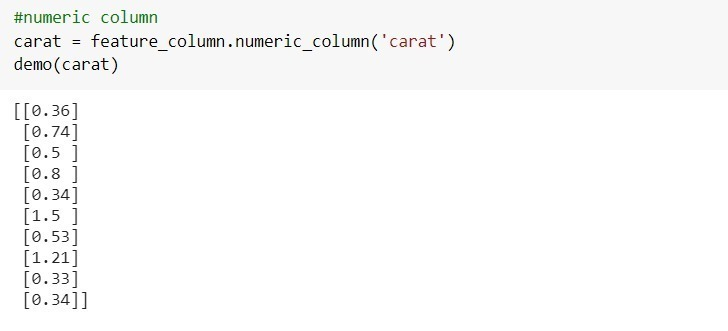

- Bucketized column: Terkadang kita memiliki dataset numerik yang memiliki value beragam dengan range cukup jauh. Daripada memasukkan setiap value ke dalam numeric column, kita dapat menggunakan bucketized column untuk membagi value-value tersebut.


In [11]:
#bucketized column
carat = feature_column.numeric_column('carat')
carat_buckets = feature_column.bucketized_column(carat, boundaries=[1, 2])
demo(carat_buckets)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'DenseFeatures'

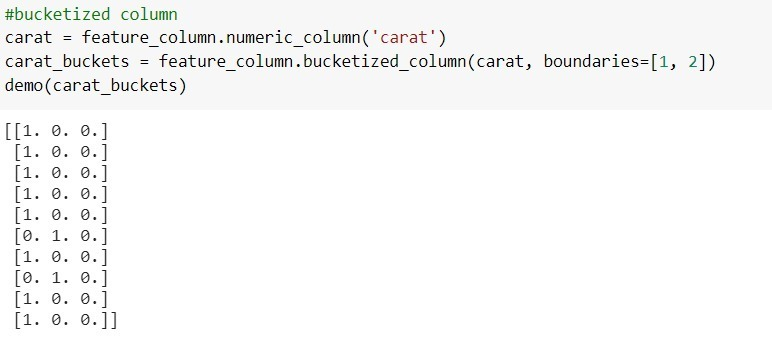

- Categorical column: Kita tidak dapat memasukkan value String ke dalam TensorFlow. Oleh karena itu, categorical column digunakan untuk mengubah value String pada dataset (pada dataset ini contohnya cut dan clarity) menjadi angka.

In [10]:
#categorical
color_type = feature_column.categorical_column_with_vocabulary_list(
        'color', ['E', 'I','J','D','H', 'G','F'])
    
color_type_one_hot = feature_column.indicator_column(color_type)
demo(color_type_one_hot)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'DenseFeatures'

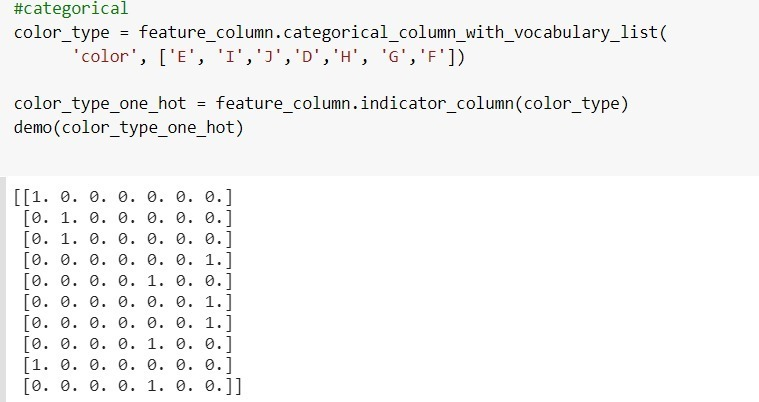

- Embedding column: Jika kita memiliki banyak value dalam satu categorical column, lalu jenis value tersebut dapat bertambah seiring dengan berjalannya waktu, data tersebut menjadi tidak cocok jika hanya direpresentasikan dengan nilai 0 atau 1 seperti categorical column. Embedding column merepresentasikan satu categorical column dengan nilai yang beragam.

*Key point*: hasil embedding column menjadi maksimal jika sebuah categorical column memiliki banyak jenis value.

In [12]:
#embedding
clarity = feature_column.categorical_column_with_vocabulary_list(
        'clarity', df.clarity.unique())
clarity_embedding = feature_column.embedding_column(clarity, dimension=6)
demo(clarity_embedding)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'DenseFeatures'

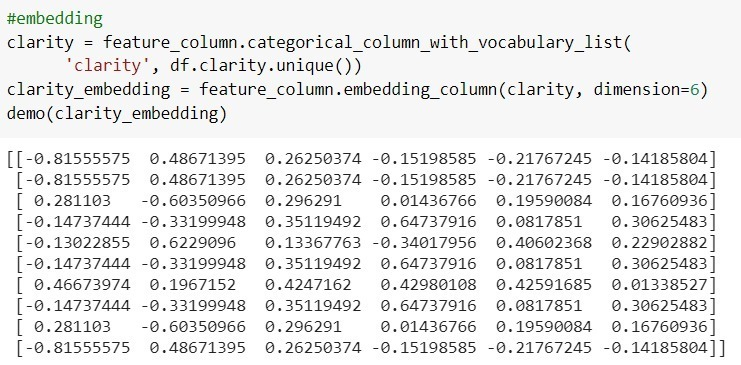

- Hashed feature column: Hashed feature column merupakan cara alternatif untuk merepresentasikan categorical column yang memiliki banyak jenis value. Kita dapat menentukan jumlah hash_buckets jauh lebih sedikit dari jumlah kategori yang sebenarnya untuk menghemat tempat.

*Key point*: kerugian dari teknik ini adalah dapat terjadi collision yang mana kategori berbeda dipetakan pada bucket yang sama.

In [13]:
#hashed feature
clarity_hashed = feature_column.categorical_column_with_hash_bucket(
        'clarity', hash_bucket_size=5)
demo(feature_column.indicator_column(clarity_hashed))

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'DenseFeatures'

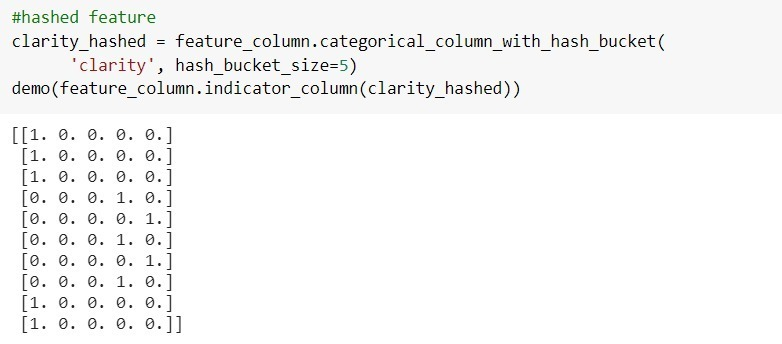

- Crossed feature column: Crossed feature column menggabungkan banyak feature column menjadi satu feature column. Crossed feature column membuat column feature baru yang memungkinkan model untuk mempelajari weight berbeda untuk setiap kombinasi dari column feature.

**Catatan**: crossed feature column tidak membuat table dari seluruh kemungkinan kombinasi feature column karena ukurannya bisa menjadi sangat besar. Sebagai gantinya, crossed feature column didukung oleh hashed feature column sehingga dapat mendefinisikan ukuran table tersebut.

In [14]:
#cross feature
#data yang di cross harus berupa string, categorical, atau bucketized
crossed_feature = feature_column.crossed_column([carat_buckets, color_type],
                                                hash_bucket_size=10)
demo(feature_column.indicator_column(crossed_feature))

Instructions for updating:
Use `tf.keras.layers.experimental.preprocessing.HashedCrossing` instead for feature crossing when preprocessing data to train a Keras model.


AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'DenseFeatures'

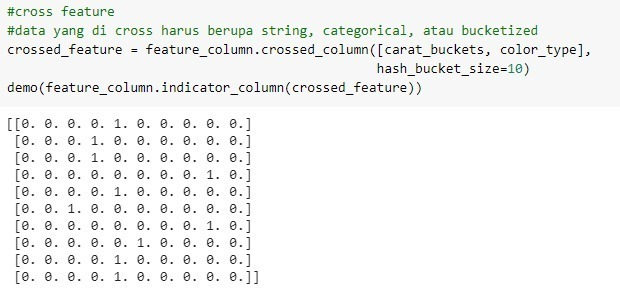

## Feature layer

Kemudian buat feature layer sebagai input ke dalam model tf.Keras.

In [15]:
#Pilih feature column mana yang akan digunakan
feature_columns = []
# numeric column
for header in ['carat', 'depth', 'x', 'y', 'z']:
    feature_columns.append(feature_column.numeric_column(header))
    
#membuat feature layer
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'DenseFeatures'

## Create, compile, train

In [16]:
#create, compile, and train the model
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1)
])
    
model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    
model.fit(train_ds,
            validation_data=val_ds,
            epochs=10)

NameError: name 'feature_layer' is not defined